In [37]:
import h5py

import os
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({
    'figure.figsize': (8,4),
    'figure.dpi': 100,
    'savefig.dpi': 100,
})

LINEWIDTH3D = 0.5
Year_in_Second = 365*24*3600

In [38]:
ResultFile = './Results/Result.jld2' 

In [39]:
with h5py.File(ResultFile) as file:
    # print(file.keys())
    History_Time = np.array(file["History_Time"]).T
    History_Time = History_Time.reshape( (len(History_Time), ) )
    History_V = np.array( file["History_V"] ).T
    History_Friction = np.array( file["History_Friction"] ).T
    History_NormalStress = np.array(file["History_NormalStress"]).T
    History_Disp = np.array(file["History_Disp"]).T
    History_Theta = np.array(file["History_Theta"]).T

# %%
with h5py.File("../Input_ExternalStressChange.jld2") as file:
    # print(file.keys())
    ExternalStress_TimeArray = np.array(file["ExternalStress_TimeArray"])
    Cm_Delta_P = np.array(file["Cm_Delta_P"]).T
    Delta_P = np.array( file["Delta_P"] ).T
    ExternalStress_Normal = np.array(file["ExternalStress_Normal"]).T
    ExternalStress_Normal_Initial = np.array(file["ExternalStress_Normal_Initial"]).T
    ExternalStress_Normal_Poro = np.array(file["ExternalStress_Normal_Poro"]).T
    ExternalStress_Shear = np.array(file["ExternalStress_Shear"]).T
    ExternalStress_Shear_Initial = np.array(file["ExternalStress_Shear_Initial"]).T
    ExternalStress_Shear_Poro = np.array(file["ExternalStress_Shear_Poro"]).T
    PorePressure = np.array( file["PorePressure"] ).T
    PorePressure_Initial = np.array( file["PorePressure_Initial"] ).T
    PorePressure_Poro = np.array( file["PorePressure_Poro"] ).T

# %%
with h5py.File("./Input_Discretized.jld2") as file:
    # print(file.keys())
    FaultCenter = np.array( file["FaultCenter"] ).T
    FaultLengthStrike = np.array(file["FaultLengthStrike"]) 
    FaultLengthDip = np.array(file["FaultLengthDip"])
    FaultStrikeAngle = np.array(file["FaultStrikeAngle"]) 
    FaultDipAngle = np.array(file["FaultDipAngle"]) 
    FaultLLRR = np.array(file["FaultLLRR"])

In [40]:
def get_rupture_start_timestep():
    for i in range(len(History_Time)):
        if np.linalg.norm(History_Disp[i]) > 1e-3:
            return i
    return None

Text(0, 0.5, 'Year')

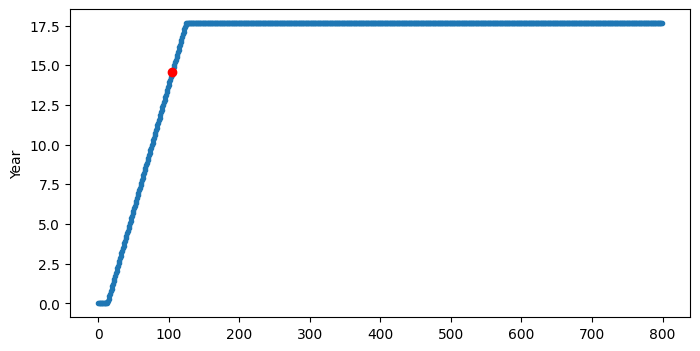

In [41]:
plt.plot( History_Time/Year_in_Second, '.' )

idx_rupture = get_rupture_start_timestep()

plt.plot( idx_rupture, History_Time[idx_rupture]/Year_in_Second,  'ro' )
plt.ylabel('Year')

In [42]:
def get_center_line(faultcenter):
    idx_CLine = np.where(  faultcenter[:,1] == 995. )[0]
    return idx_CLine, faultcenter[idx_CLine]

idx_CenterLine, CenterLine = get_center_line(FaultCenter)

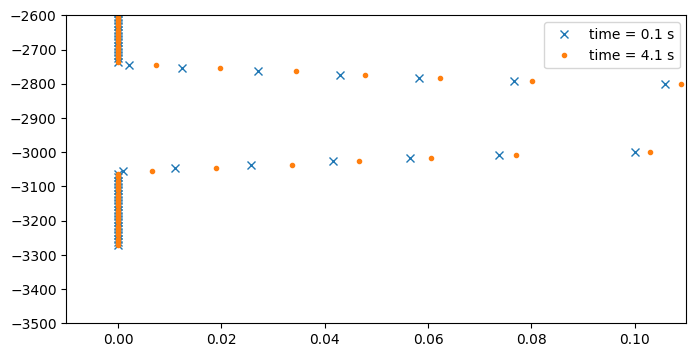

In [43]:
idx_time1 = idx_rupture+100
idx_time2 = -1

def get_time_since_rupture(idx_time):
    nucleation_idx = 80
    return (History_Time[idx_time]-History_Time[idx_rupture+nucleation_idx])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( History_Disp[idx_time1, idx_CenterLine], -CenterLine[:,2], 'x', label=f'time = {get_time_since_rupture(idx_time1):.1f} s' )
ax.plot( History_Disp[idx_time2, idx_CenterLine], -CenterLine[:,2], '.', label=f'time = {get_time_since_rupture(idx_time2):.1f} s')
ax.legend()
ax.set_xscale('linear')
ax.set_xlim(-0.01, 0.11)
ax.set_ylim(-3500, -2600);

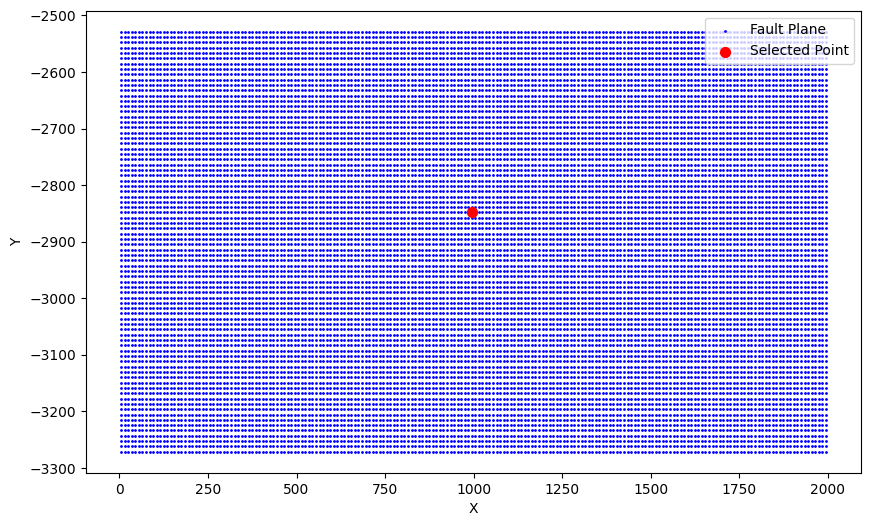

In [44]:
# Select a point index, for example, the first point in the center line
point_index = idx_CenterLine[45]

# Get the coordinates of the selected point
point_coordinates = FaultCenter[point_index]

# Plot the fault plane and the selected point
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot( 111 )

# Plot the fault plane
ax.scatter(FaultCenter[:, 1], -FaultCenter[:, 2], s=1, c='b', label='Fault Plane')

# Plot the selected point
ax.scatter(point_coordinates[1], -point_coordinates[2], s=50, c='r', label='Selected Point')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

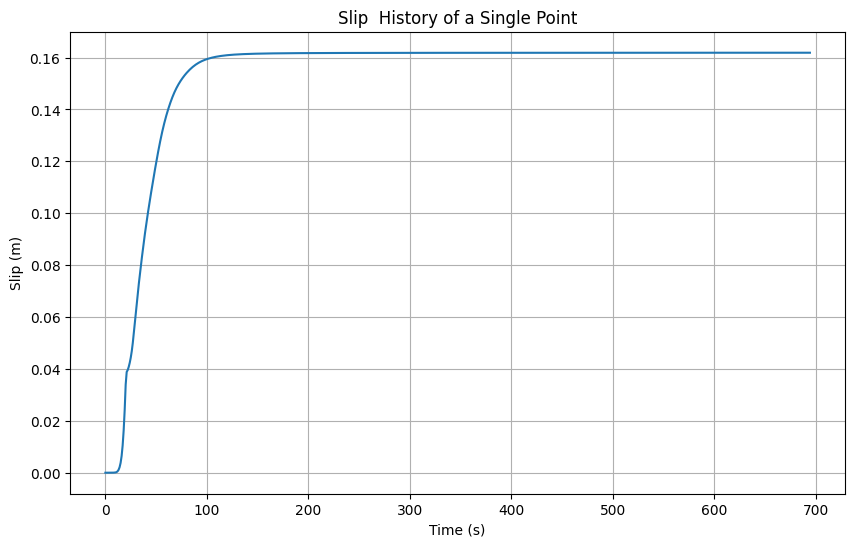

In [45]:
# Plot the slip history for the selected point
plt.figure(figsize=(10, 6))
plt.plot(History_Disp[idx_rupture:, point_index], )
plt.xlabel('Time (s)')
plt.ylabel('Slip (m)')
plt.title('Slip  History of a Single Point')
plt.grid(True)
# plt.yscale('log')
plt.show()

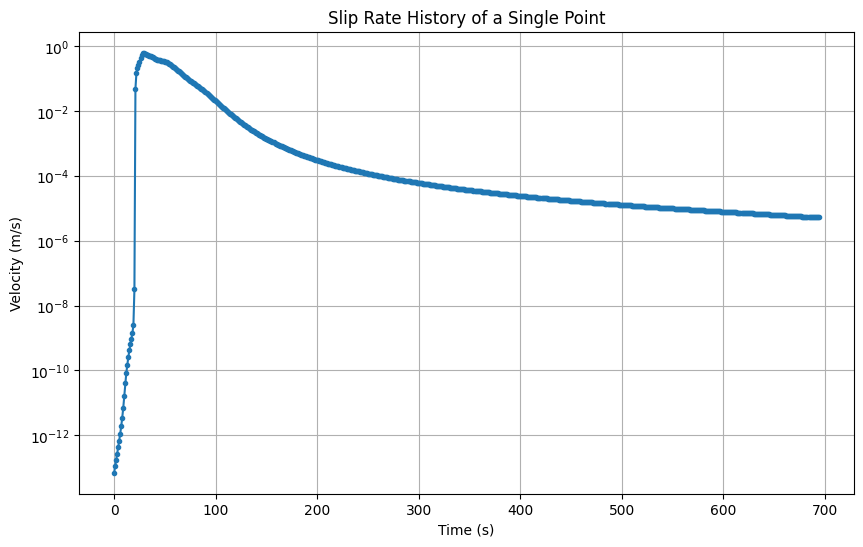

In [46]:
# Plot the slip history for the selected point
plt.figure(figsize=(10, 6))
plt.plot(History_V[idx_rupture:, point_index], '.-')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Slip Rate History of a Single Point')
plt.grid(True)
plt.yscale('log')
plt.show()

In [47]:
History_Friction.shape

(800, 16000)

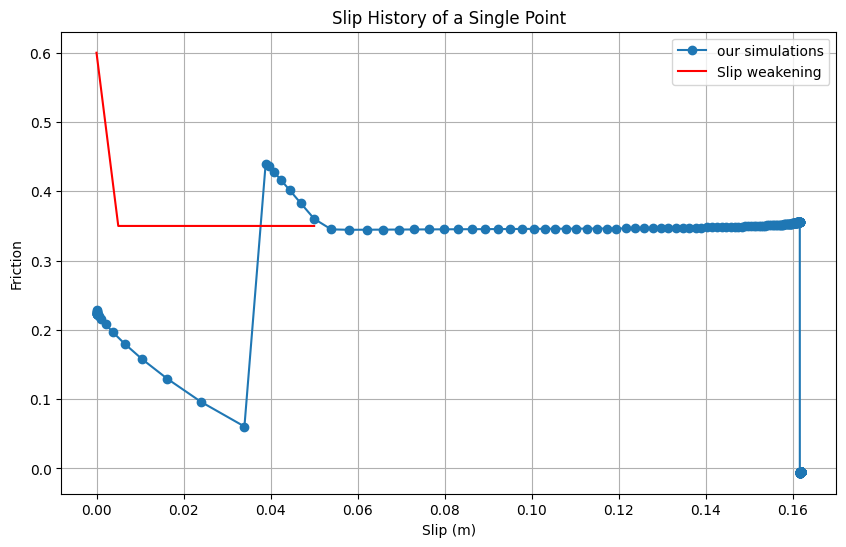

In [48]:
# Plot the slip history for the selected point
plt.figure(figsize=(10, 6))
plt.plot(History_Disp[idx_rupture:, point_index], History_Friction[idx_rupture:, point_index], 'o-',label='our simulations' )
plt.plot([0.0, 5e-3,0.05],[0.6,0.35,0.35],'r-',label='Slip weakening')
plt.xlabel('Slip (m)')
plt.ylabel('Friction')
plt.legend()
plt.title('Slip History of a Single Point')
plt.grid(True)
plt.show()